# Proof-of-concept: Muse cube ingestion to InfluxDB

In [15]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import gc
import resource

import pyfits as fits
from scipy.stats import norm

In [16]:
t_0 = time.time()
filename = "muse_scipost_N_SN2009bb_DATACUBE_FINAL_IFU_001_zap.fits"
data = fits.open(filename)
image = data[1].data
header = data[1].header
del data

t_1 = time.time()
read_time = (t_1-t_0)
print("Read time: %f" % read_time)

gc.collect()
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss


Read time: 0.053934


1346703360

0.0 1016737.16562


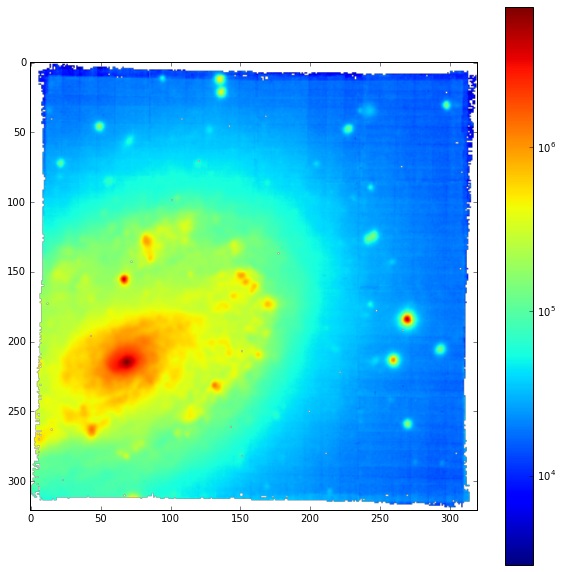

In [17]:
(nl, nx, ny) = np.shape(image)

# integrate all lambdas 
image2D = np.sum(image, axis = 0)

# get only one lambda
#image2D = image[2000,:,:]

# remove the nans and remove the negatives
image2D[np.invert(np.isfinite(image2D))] = 0

# create the plot canvas
fig, ax = plt.subplots(figsize = (10, 10))

# get max and min of values
l1, l2 = (np.percentile(image2D.flatten(), 1), np.percentile(image2D.flatten(), 99))
print(l1, l2)

# show the images
color = ax.imshow(image2D,norm=LogNorm());
#color = ax.imshow(image2D);

# add the colorbar
fig.colorbar(color)


### get a spectra from a pixlel

(4748.47607421875, 9348.47607421875)

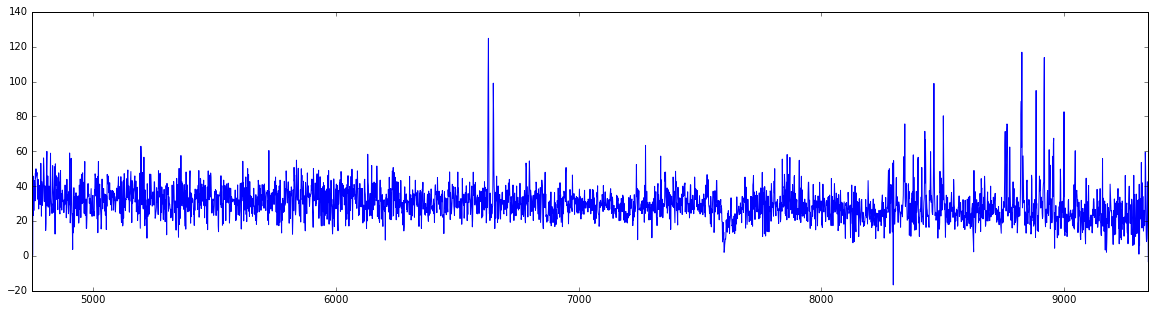

In [18]:
CRVAL3 = float(header["CRVAL3"])
CRPIX3 = float(header["CRPIX3"])
CUNIT3 = header["CUNIT3"]
CD31 = float(header["CD3_1"])
CD32 = float(header["CD3_2"])
CD33 = float(header["CD3_3"])
NAXIS3 = int(header["NAXIS3"])

lambdas = np.array(CRVAL3 + CD33 * (np.arange(NAXIS3) - CRPIX3))

x=120
y=50

fig, ax = plt.subplots(figsize = (20, 5))
spectra = image[:, x, y]

#ax.semilogy(lambdas, spectra)
ax.plot(lambdas,spectra)
ax.set_xlim(min(lambdas), max(lambdas))


In [19]:
320*321*3681/1024/1024*8

2884.76806640625

### Put the spectra in the influxDB

In [20]:
from influxdb import InfluxDBClient

json_body = [
    {
        "measurement": "cpu_load_short",
        "tags": {
            "host": "server01",
            "region": "us-west"
        },
        "time": "2009-11-10T23:00:00Z",
        "fields": {
            "value": 0.64
        }
    }
]

client = InfluxDBClient('localhost', 8086, 'root', 'root', 'example')

client.create_database('example')

client.write_points(json_body)

result = client.query('select value from cpu_load_short;')

print("Result: {0}".format(result))

Result: ResultSet({'('cpu_load_short', None)': [{'time': '2009-11-10T23:00:00Z', 'value': 0.64}]})


In [21]:
from influxdb import InfluxDBClient
import json

object = header["OBJECT"]


i=0
t_idx=0
dx=range(10,300)
dy=range(10,300)

client = InfluxDBClient('localhost', 8086, 'root', 'root', 'test')

client.create_database('test')

t_0 = time.time()
for x in dx:
    for y in dy:
        i=0
        points = []
        spectra = image[:, x, y]
        for l in lambdas:
            t_idx=t_idx+1
            if (not np.isfinite(spectra[i])):
                spectra[i]=0
            point = {
                "measurement": object,
                "time": t_idx,
                "fields": {
                    "x":x,
                    "y":y,
                    "lambda": l,
                    "value": spectra[i]
                }
            }
            i=i+1
            points.append(point)
        client.write_points(points)
        del points
t_1 = time.time()
write_time=(t_1-t_0)
print("write time: %f" % write_time)

write time: 10952.926258


In [23]:
10952.926258/60/60

3.042479516111111

In [26]:
factor = 100000000
result = client.query('select * from "{0} where (time/{1}) > 2000";'.format(object,factor))

print("Result: {0}".format(result))

Result: ResultSet({})


In [28]:
factor = 10
result = client.query('select * from "{0} where (time/{1}) > 2";'.format(object,factor))

print("Result: {0}".format(result))

Result: ResultSet({})
